In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


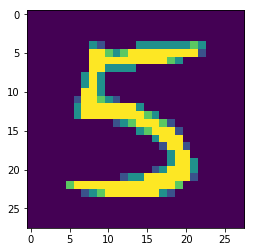

In [4]:
plt.imshow(mnist.train.images[1200, :].reshape(28, 28))

In [114]:
learning_rate = 0.0001
epochs = 2000
batch_size = 100
display_step = 100

n_input = 784
n_classes = 10

In [115]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes])
keep_prob = tf.placeholder(dtype=tf.float32)

In [116]:
# 卷积函数
# strides: NHWC 长度为 4 的列表： [batch, height, width, channel]
def conv2d(x, W, b, strides=1):
    """Conv2d wrapper with bias and relu activation"""
    x = tf.nn.conv2d(input=x, filter=W, strides=[1, strides, strides, 1], padding="SAME")
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# 最大池化函数：2*2像素 -> 1*1,保留灰度最大的像素
def maxpool2d(x, size=2, strides=2):
    """MaxPool2d wrapper"""
    ksize = [1, size, size, 1]
    strides = [1, strides, strides, 1]
    return tf.nn.max_pool(value=x, ksize=ksize, strides=strides, padding="SAME")

# 卷积网络构造函数
# weights、biases 都是词典
def conv_net(x, weights, biases, keep_prob):
    # reshape input
    x_image = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    # conv layer 1 -> [-1, 28, 28, 32]
    conv1 = conv2d(x_image, W=weights["wc1"], b=biases["bc1"], strides=1)
    # max_pooling 1 -> [-1, 14, 14, 32]
    pool1 = maxpool2d(conv1, size=2, strides=2)
    
    # conv layer 2 -> [-1, 14, 14, 64]
    conv2 = conv2d(pool1, W=weights["wc2"], b=biases["bc2"], strides=1)
    # max_pooling 2 -> [-1, 7, 7, 64]
    pool2 = maxpool2d(conv2, size=2, strides=2)
    
    # FC [-1, 7 * 7 * 64] -> [-1, 1024]
    x_image = tf.reshape(pool2, shape=[-1, weights["wd1"].shape[0]])
    fc1 = tf.nn.relu(x_image @ weights["wd1"] + biases["bd1"])
    
    # Dropout:
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    # Output: [-1, 1024] -> [-1, 10]
    out = fc1_drop @ weights["out"] + biases["out"]
    return out    

In [117]:
weights = {
    "wc1": tf.Variable(tf.random_normal(shape=[5, 5, 1, 32])),
    "wc2": tf.Variable(tf.random_normal(shape=[5, 5, 32, 64])),
    "wd1": tf.Variable(tf.random_normal(shape=[7 * 7 * 64, 1024])),
    "out": tf.Variable(tf.random_normal(shape=[1024, n_classes]))
}

biases = {
    "bc1": tf.Variable(tf.random_normal(shape=[32])),
    "bc2": tf.Variable(tf.random_normal(shape=[64])),
    "bd1": tf.Variable(tf.random_normal(shape=[1024])),
    "out": tf.Variable(tf.random_normal(shape=[n_classes]))
}

In [118]:
### 重要算子
pred = conv_net(X, weights, biases, keep_prob)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred), axis=1), axis=0)  ## 指数计算容易计算溢出
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=1), 
                                      tf.argmax(pred, axis=1)), 
                             dtype=tf.float32))
init = tf.global_variables_initializer()

### 测试集
test_holder = {X: mnist.test.images[:1000, :], y: mnist.test.labels[:1000, :], keep_prob: 1.0}

In [119]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [120]:
sess.run(init)
for epoch in range(epochs):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={X: batch_xs, y: batch_ys, keep_prob: 0.75})
    if epoch % display_step == 0:
        train_cost = sess.run(cross_entropy, feed_dict={X: batch_xs, y: batch_ys, keep_prob: 0.75})
        test_acc = sess.run(acc, feed_dict=test_holder)
        print("epoch %d, test_acc: %.4f, train_cost: %.4f" % (epoch, test_acc, train_cost))

epoch 0, test_acc: 0.0510, train_cost: 101871.0781
epoch 100, test_acc: 0.3610, train_cost: 40971.6484
epoch 200, test_acc: 0.5540, train_cost: 30495.3359
epoch 300, test_acc: 0.6580, train_cost: 18602.6035
epoch 400, test_acc: 0.7220, train_cost: 13381.7334
epoch 500, test_acc: 0.7680, train_cost: 9402.9004
epoch 600, test_acc: 0.7940, train_cost: 12025.6777
epoch 700, test_acc: 0.8120, train_cost: 7133.4595
epoch 800, test_acc: 0.8300, train_cost: 6089.6719
epoch 900, test_acc: 0.8390, train_cost: 6699.2964
epoch 1000, test_acc: 0.8560, train_cost: 4851.0200
epoch 1100, test_acc: 0.8680, train_cost: 4641.5903
epoch 1200, test_acc: 0.8720, train_cost: 4370.4956
epoch 1300, test_acc: 0.8700, train_cost: 5747.7388
epoch 1400, test_acc: 0.8910, train_cost: 4681.9971
epoch 1500, test_acc: 0.8900, train_cost: 3001.6157
epoch 1600, test_acc: 0.8960, train_cost: 2847.6460
epoch 1700, test_acc: 0.8980, train_cost: 2133.0293
epoch 1800, test_acc: 0.9000, train_cost: 2824.3245
epoch 1900, test_